Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, explained_variance_score)
from sklearn.impute import SimpleImputer

In [2]:
# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    has_xgb = True
except ImportError:
    has_xgb = False

Load Data & Feature Engineering

In [3]:
df = pd.read_csv('emissions.csv')

# Select relevant columns
features = [
    'Year', 'Savanna fires', 'Forest fires', 'Crop Residues',
    'Rice Cultivation', 'Food Transport', 'Rural population',
    'Urban population', 'total_emission'
]
df = df[features]

# Feature engineering
df['total_population'] = df['Rural population'] + df['Urban population']
df['urbanization_rate'] = df['Urban population'] / df['total_population']
df['fire_contribution'] = df['Savanna fires'] + df['Forest fires']
df['agricultural_impact'] = df['Crop Residues'] + df['Rice Cultivation']

print(df)

      Year  Savanna fires  Forest fires  Crop Residues  Rice Cultivation  \
0     1990        14.7237        0.0557       205.6077          686.0000   
1     1991        14.7237        0.0557       209.4971          678.1600   
2     1992        14.7237        0.0557       196.5341          686.0000   
3     1993        14.7237        0.0557       230.8175          686.0000   
4     1994        14.7237        0.0557       242.0494          705.6000   
...    ...            ...           ...            ...               ...   
6960  2016      1190.0089      232.5068        70.9451            7.4088   
6961  2017      1431.1407      131.1324       108.6262            7.9458   
6962  2018      1557.5830      221.6222       109.9835            8.1399   
6963  2019      1591.6049      171.0262        45.4574            7.8322   
6964  2020       481.9027       48.4197       108.3022            7.9733   

      Food Transport  Rural population  Urban population  total_emission  \
0          

Prepare Features & Target with Imputation and Scaling

In [4]:
X = df.drop('total_emission', axis=1)
y = df['total_emission']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model Comparison

In [5]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

if has_xgb:
    models['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42)

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results.append({
        'Model': name,
        'R²': round(r2_score(y_test, y_pred), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    })

results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
print("\nModel Comparison:")
print(results_df)

c:\Users\Aditi Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e+13, tolerance: 2.666e+10
  model = cd_fast.enet_coordinate_descent(



Model Comparison:
               Model      R²         RMSE
4      Random Forest  0.9863   30809.1992
7            XGBoost  0.9851   32137.0860
5  Gradient Boosting  0.9845   32706.6904
3      Decision Tree  0.9584   53662.5897
0  Linear Regression  0.9236   72682.5045
1              Ridge  0.9236   72712.5416
2              Lasso  0.9236   72720.0570
6                SVR -0.0485  269315.2035


Hyperparameter Tuning (Random Forest)

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('transformer', PowerTransformer()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 15, None],
    'model__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best R² Score: 0.9862170652596498


Evaluation

In [7]:
def calculate_metrics(y_true, y_pred, set_name):
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'Explained Variance': explained_variance_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }
    print(f"\n{set_name} Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    return metrics

y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")


Training Metrics:
R²: 0.9982
Explained Variance: 0.9982
MAE: 2245.7457
MSE: 88381335.4371
RMSE: 9401.1348

Test Metrics:
R²: 0.9869
Explained Variance: 0.9869
MAE: 5722.6246
MSE: 905202565.5673
RMSE: 30086.5845


Visualization

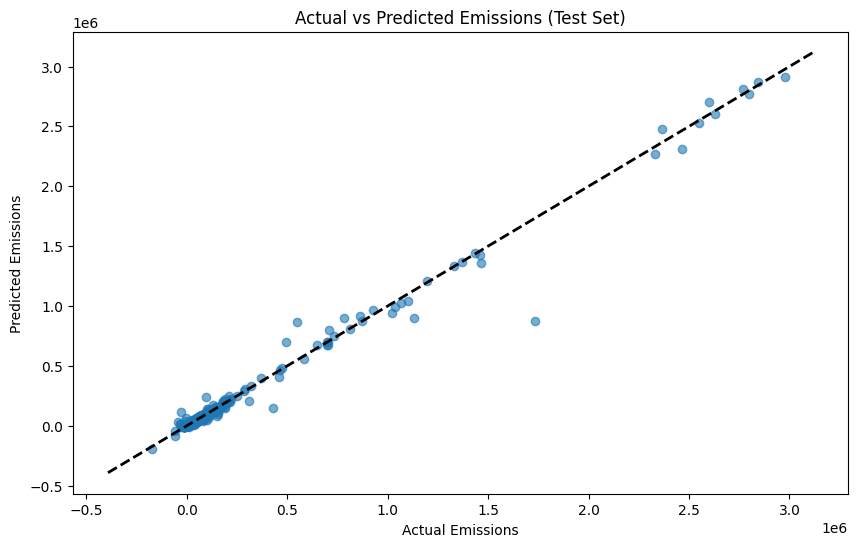

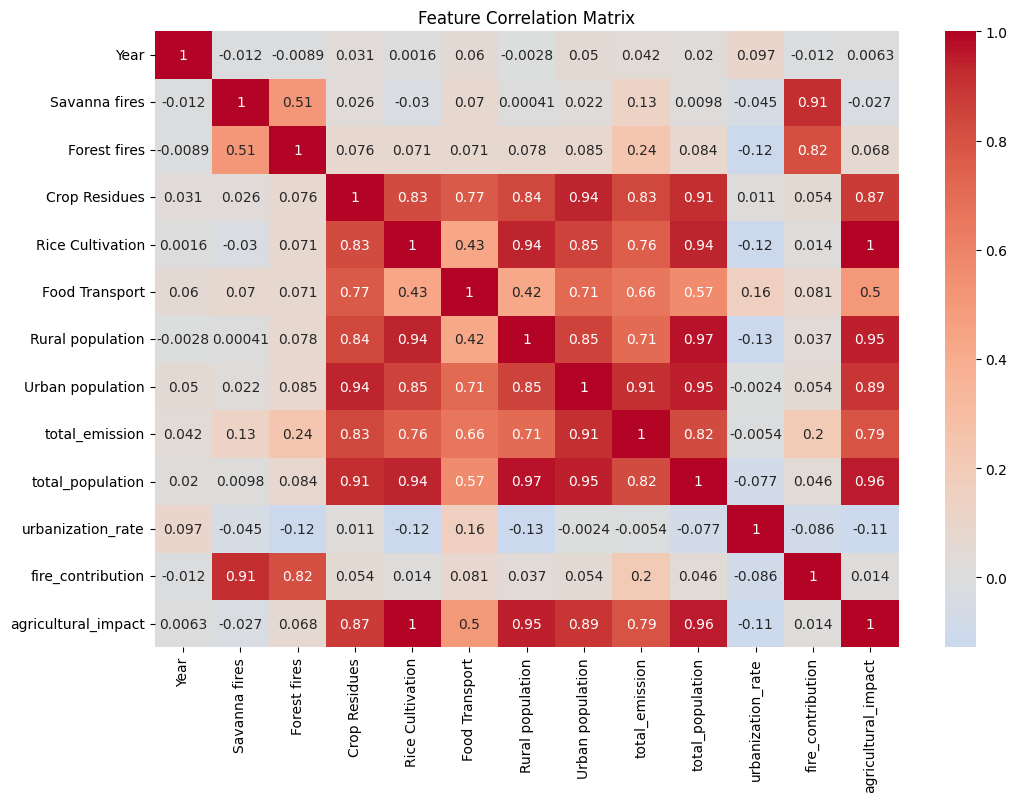

In [8]:
# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Emissions')
plt.ylabel('Predicted Emissions')
plt.title('Actual vs Predicted Emissions (Test Set)')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

Model Saving & Sample Prediction

In [9]:
# Save model and metadata
os.makedirs('model', exist_ok=True)
joblib.dump(best_pipeline, 'model/emission_model.joblib')

model_metadata = {
    'features': list(X.columns),
    'target': 'total_emission',
    'metrics': {
        'train': train_metrics,
        'test': test_metrics
    }
}
joblib.dump(model_metadata, 'model/model_metadata.joblib')
print("Model and metadata saved successfully")

Model and metadata saved successfully


In [10]:
# Predict on sample
sample_input = X_test.iloc[0:1]
prediction = best_pipeline.predict(sample_input)
print(f"\nPredicted Emission: {prediction[0]:.2f}")
print(f"Actual Emission: {y_test.iloc[0]:.2f}")


Predicted Emission: 9766.53
Actual Emission: 9797.21
